<a href="https://colab.research.google.com/github/SaeedTafazzol/digit_generator/blob/main/cnn_BVAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from matplotlib import pyplot as plt
from torch.distributions import *


dataset1 = datasets.MNIST('../data', train=True,transform=transforms.ToTensor(), download=True)
dataset2 = datasets.MNIST('../data', train=False,transform=transforms.ToTensor())


train_loader = torch.utils.data.DataLoader(dataset1,batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset2,batch_size=64, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



In [ ]:

p = Normal(torch.tensor([0.0]), torch.tensor([1.0]))
q = Normal(torch.tensor([0.0]), torch.tensor([1.0]))
print(kl_divergence(p,q))
torch.eye(3)

tensor([0.])


tensor([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]])

In [ ]:
p = torch.distributions.MultivariateNormal(torch.zeros((2,3,)),torch.stack((torch.eye(3),(torch.eye(3)))))
q = torch.distributions.MultivariateNormal(torch.ones((2,3,)), torch.stack((torch.eye(3),(torch.eye(3)))))

kl_divergence(p,q)



tensor([1.5000, 1.5000])

In [ ]:
torch.tensor(torch.tensor(False),dtype=float)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.


tensor(0., dtype=torch.float64)

In [ ]:
class Encoder(nn.Module):
  def __init__(self,z=10):
    super(Encoder, self).__init__()

    # self.l1 = nn.Linear(28*28,256)
    self.conv1 = nn.Conv2d(1,6,(4,4),stride=3)
    self.conv2 = nn.Conv2d(6,10,(3,3),stride=2)
    
    self.fc = nn.Linear(10*4*4,64)    
 
    self.mean = nn.Linear(64 ,10)
    self.log_std = nn.Linear(64 ,10)

  def forward(self, img):
    out = F.leaky_relu(self.conv1(img))
    out = F.leaky_relu(self.conv2(out))

    out = out.reshape(-1,10*4*4)
    out = F.leaky_relu(self.fc(out))
    mean = 	F.tanh(self.mean(out))
    log_std = self.log_std(out)
    return mean,log_std


class Decoder(nn.Module):
  def __init__(self):
    super(Decoder, self).__init__()

    self.fc1 = nn.Linear(10,64)
    self.fc2 = nn.Linear(64,10*4*4)
    self.conv1 = nn.Conv2d(10,6,(3,3),padding='same')
    self.conv2 = nn.Conv2d(6,1,(4,4),padding='same')

  def forward(self, lat):
    out = F.leaky_relu(self.fc1(lat))
    out = F.leaky_relu(self.fc2(out))
    out = out.reshape(-1,10,4,4)
    out = F.leaky_relu(self.conv1(F.interpolate(out,(9,9))))
    out = F.sigmoid(self.conv2(F.interpolate(out,(28,28))))
    return	out


In [ ]:
class autoencoder(object):
  def __init__(self):
    self.decoder = Decoder().to(device)
    self.encoder = Encoder().to(device)
    self.optimizer =  torch.optim.Adam(list(self.encoder.parameters())+list(self.decoder.parameters()),lr=1e-3)



  def train(self,data_loader):
    img, label = next(iter(data_loader))
    img = img.to(device)
    label = label.to(device)
    beta = 5

    mean,log_std = self.encoder(img)
    # print(var.shape)
    # var = torch.full((var.shape[1],), var)
    # cov_mat = torch.diag(var,dim=-1)#.unsqueeze(dim=0)
    # print(cov_mat)
    # print(cov_mat.shape)

    var = torch.exp(2*log_std)
 
    a = torch.arange(0,var.shape[1]).to(device)
    cov_mat = torch.zeros((var.shape[0],var.shape[1],var.shape[1])).to(device)
    cov_mat[:,a,a] = var

    nor_dist = torch.distributions.MultivariateNormal(mean, cov_mat)

    standard_nor = torch.distributions.MultivariateNormal(torch.zeros(mean.shape[1]).to(device), torch.eye(cov_mat.shape[1]).to(device))

    latent = standard_nor.sample((mean.shape[0],))*torch.exp(log_std) + mean

    bern = self.decoder(latent)
    
    # ber_dist = Bernoulli(bern)
    
    # generated = ber_dist.sample().reshape(-1,1,28,28)
    
    # bin_img = (img.reshape(-1,28*28)>0.5).float()
    # print(ber_dist.log_prob(bin_img).shape)
    # loss =  -ber_dist.log_prob(bin_img).sum(1).mean() + beta*kl_divergence(nor_dist,standard_nor).mean(0)#nn.MSELoss()(img,generated)#nn.CrossEntropyLoss()(labeled,label) +
    # print(nn.BCELoss()(bern,img.reshape(-1,28*28)).shape)
    loss =  nn.BCELoss(reduction='sum')(bern,img)/torch.tensor(64) + beta*kl_divergence(nor_dist,standard_nor).mean(0)
    self.optimizer.zero_grad()


    loss.backward()
    # torch.nn.utils.clip_grad_norm_(self.encoder.parameters(), 10)
    # torch.nn.utils.clip_grad_norm_(self.decoder.parameters(), 10)

    self.optimizer.step()
    
    return loss



In [ ]:
auto = autoencoder()
loss = 0

for i in range(1001):
  loss+= auto.train(train_loader)
  if (i+1)%100==0:
    print(i,loss/100)
    loss = 0

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/conv.py:443: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  ../aten/src/ATen/native/Convolution.cpp:647.)
  self.padding, self.dilation, self.groups)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


99 tensor(298.4955, grad_fn=<DivBackward0>)
199 tensor(212.4996, grad_fn=<DivBackward0>)
299 tensor(205.8803, grad_fn=<DivBackward0>)
399 tensor(201.4305, grad_fn=<DivBackward0>)
499 tensor(198.1629, grad_fn=<DivBackward0>)
599 tensor(196.3001, grad_fn=<DivBackward0>)
699 tensor(195.1689, grad_fn=<DivBackward0>)
799 tensor(193.3966, grad_fn=<DivBackward0>)
899 tensor(190.2825, grad_fn=<DivBackward0>)
999 tensor(189.6703, grad_fn=<DivBackward0>)


In [ ]:
for i in range(101):
  loss+= auto.train(train_loader)
  if (i+1)%100==0:
    print(i,loss/100)
    loss = 0

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


99 tensor(188.9443, grad_fn=<DivBackward0>)


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


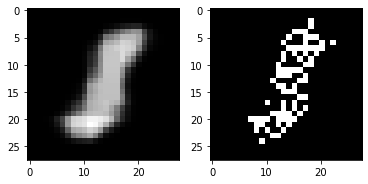

In [ ]:
# i = 901


f, axarr = plt.subplots(1,2)

# genr = auto.decoder(auto.encoder(dataset2[i][0].to(device)))
# img = dataset2[i][0]
# bin_img = (img>0.5).float()

# plt.imshow(bin_img.detach().cpu().squeeze(),cmap='gray')
standard_nor = torch.distributions.MultivariateNormal(torch.zeros(10,).to(device), torch.eye(10,).to(device))

latent = standard_nor.sample()

bern = auto.decoder(latent)

ber_dist = Bernoulli(bern)


generated_smooth = bern.reshape(-1,1,28,28)
generated_sample = ber_dist.sample().reshape(-1,1,28,28)
# plt.imshow(generated.detach().cpu().squeeze(),cmap='gray')


axarr[0].imshow(generated_smooth.detach().cpu().squeeze(),cmap='gray')
axarr[1].imshow(generated_sample.detach().cpu().squeeze(),cmap='gray')